## Setup

In [15]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.multiclass import OneVsOneClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, cross_val_predict
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import joblib

## Load data and prepare windows

In [16]:
data = pd.read_csv('training_data.csv')

# Filter for the activities
data = data[data['activity'].isin(['sit', 'walk', 'run', 'turn CW'])]

# Prepare features (windowing) 
WINDOW_SIZE = 100 # 2 seconds at 50Hz
def compute_window_features(ax, ay, az):
    ax = np.array(ax)
    ay = np.array(ay)
    az = np.array(az)
    a_mag = np.sqrt(ax**2 + ay**2 + az**2)
    return [np.mean(ax), np.mean(ay), np.mean(az), np.mean(a_mag), 
            np.std(ax), np.std(ay), np.std(az), np.std(a_mag), 
            np.var(a_mag)]

STEP_SIZE = WINDOW_SIZE // 4  # 75% overlap

windows_features = []
windows_labels = []
windows_activities = []

# Loop with step of 25 steps
for start in range(0, len(data) - WINDOW_SIZE, STEP_SIZE):
    window = data.iloc[start : start + WINDOW_SIZE]

    ax = window['Ax'].values
    ay = window['Ay'].values
    az = window['Az'].values
    acts = window['activity'].values

    # Compute features for the window
    features = compute_window_features(ax, ay, az)
    windows_features.append(features)

    # Label by most common activity in the window
    most_common = window['activity'].mode()[0]
    windows_labels.append(most_common)

    windows_activities.append(list(acts))


X = np.array(windows_features)
y = np.array(windows_labels)

## Prepare training/test set

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## Scale features, tune hyperparameters

In [18]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Hyperparameter tuning with GridSearchCV 
param_grid = {
    'estimator__C': [1, 10, 100],
    'estimator__kernel': ['linear', 'rbf'],
    'estimator__probability': [True] 
}

grid = GridSearchCV(
    OneVsOneClassifier(SVC(probability=True)),
    param_grid,
    cv=5,
    scoring='accuracy'
)

grid.fit(X_train_scaled, y_train)

print("Best params:", grid.best_params_)
print("Best CV score:", grid.best_score_)

Best params: {'estimator__C': 10, 'estimator__kernel': 'rbf', 'estimator__probability': True}
Best CV score: 0.9920701754385964


## Train and Validate Model

Cross-validation accuracy scores: [1.         1.         0.97368421 1.         1.         0.97368421
 1.         1.         0.97297297 0.97297297]
Mean CV accuracy: 0.9893314366998579


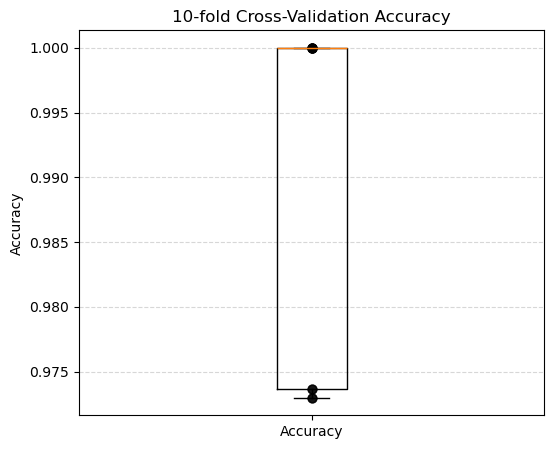

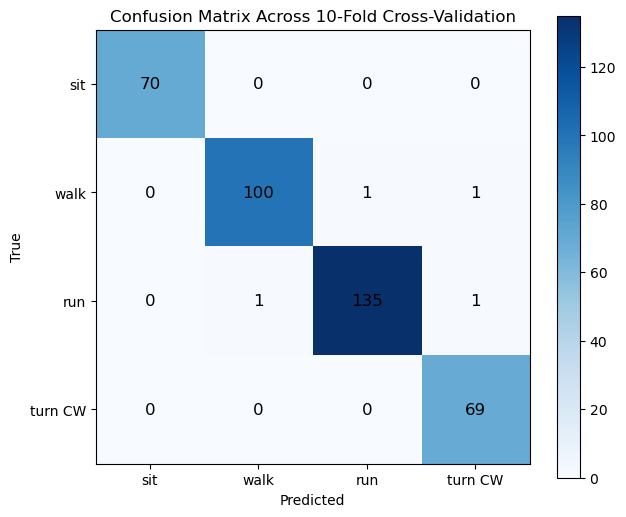

In [19]:
# train SVM with best params, one-vs-one classification
model = OneVsOneClassifier(SVC(kernel=grid.best_params_['estimator__kernel'], C=grid.best_params_['estimator__C'], probability=True))
model.fit(X_train_scaled, y_train)

# SVM Model Validation 
# Validate with 10-fold cross-validation
# use k = 10 since smaller dataset
scores = cross_val_score(
    OneVsOneClassifier(SVC(kernel=grid.best_params_['estimator__kernel'], C=grid.best_params_['estimator__C'], probability=True)),
    X_train_scaled,
    y_train,
    cv=10,
    scoring='accuracy'
)

y_pred_cv = cross_val_predict(
    OneVsOneClassifier(SVC(kernel=grid.best_params_['estimator__kernel'], C=grid.best_params_['estimator__C'], probability=True)),
    X_train_scaled,
    y_train,
    cv=10
)

print("Cross-validation accuracy scores:", scores)
print("Mean CV accuracy:", scores.mean())

# Plot cross-validation scores
plt.figure(figsize=(6, 5))
plt.boxplot(scores, vert=True)

# Also plot individual points
plt.scatter(
    [1]*len(scores), scores, 
    color='black', s=40, alpha=0.7
)   

plt.title("10-fold Cross-Validation Accuracy")
plt.ylabel("Accuracy")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.xticks([1], ['Accuracy'])
plt.show()

# Confusion matrix for CV predictions
cm_cv = confusion_matrix(y_train, y_pred_cv)
classes = ["sit", "walk", "run", "turn CW"]

plt.figure(figsize=(7,6))
plt.imshow(cm_cv, cmap="Blues")
plt.colorbar()

plt.xticks(np.arange(len(classes)), classes)
plt.yticks(np.arange(len(classes)), classes)

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, cm_cv[i,j], ha='center', va='center', color='black', fontsize=12)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix Across 10-Fold Cross-Validation")
plt.show()

## Evaluate on test set

Classification Report:
               precision    recall  f1-score   support

         run       1.00      1.00      1.00        18
         sit       1.00      1.00      1.00        25
     turn CW       1.00      1.00      1.00        35
        walk       1.00      1.00      1.00        17

    accuracy                           1.00        95
   macro avg       1.00      1.00      1.00        95
weighted avg       1.00      1.00      1.00        95

Confusion Matrix:
 [[18  0  0  0]
 [ 0 25  0  0]
 [ 0  0 35  0]
 [ 0  0  0 17]]


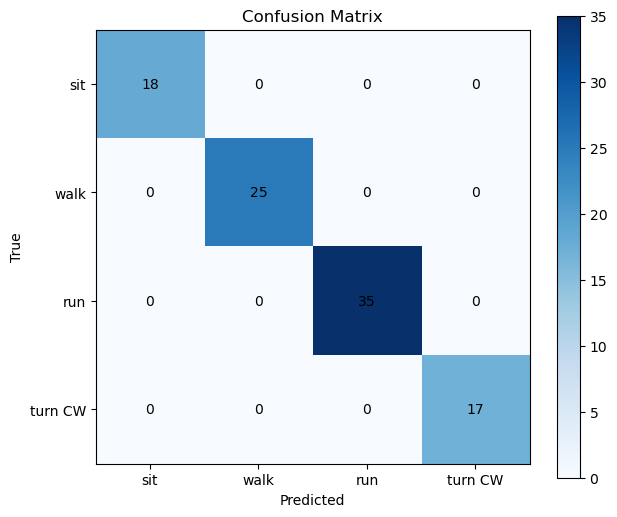

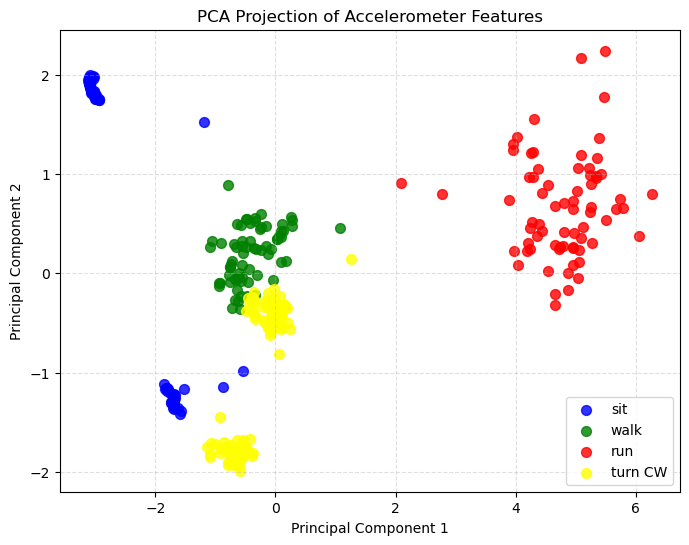

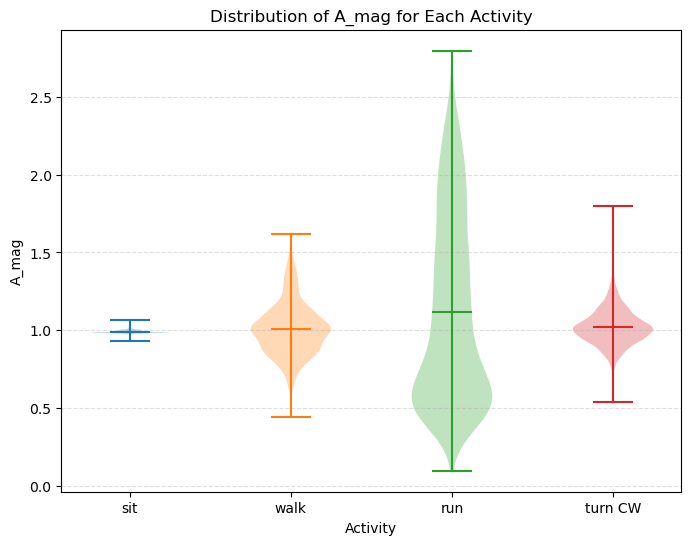

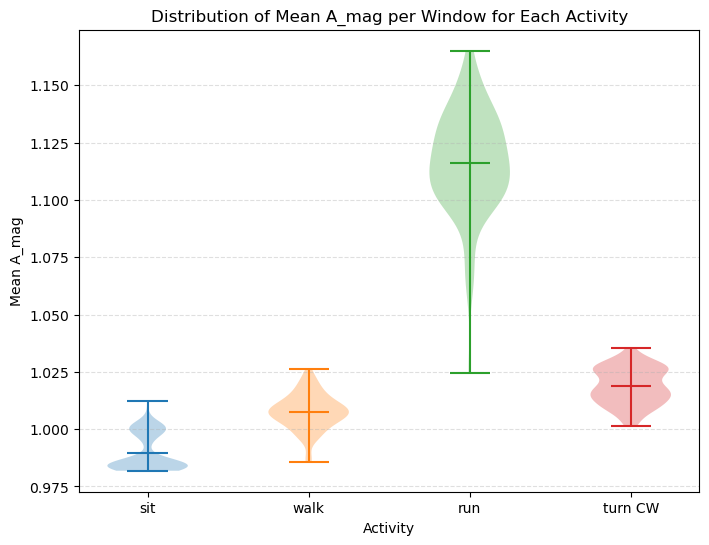

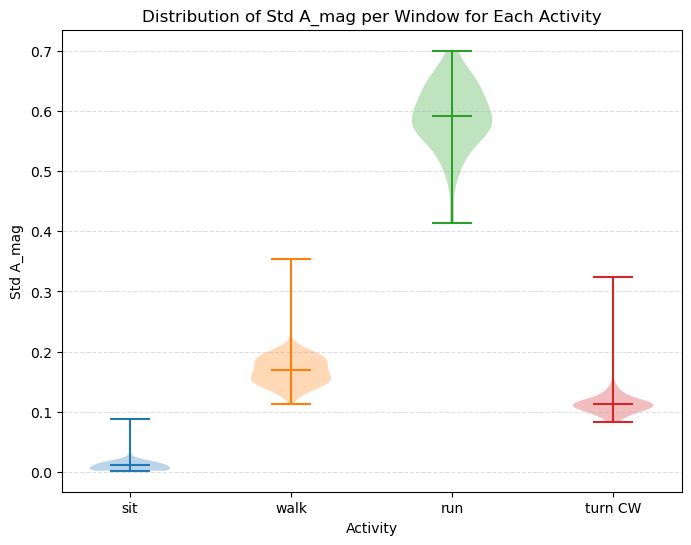

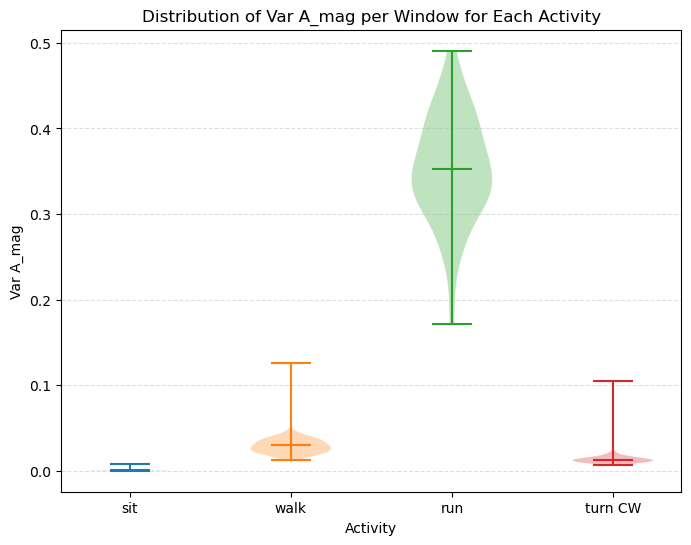

In [ ]:
# evauluate test set
y_pred = model.predict(X_test_scaled)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Visualize on test data 
# a) confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Visualize Confusion Matrix
plt.figure(figsize=(7,6))
plt.imshow(cm, cmap="Blues")
plt.colorbar()

classes = ["sit", "walk", "run", "turn CW"]

# Axis labels
plt.xticks(np.arange(4), classes)
plt.yticks(np.arange(4), classes)
# label squares
for i in range(4):
    for j in range(4):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="black")

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# b) PCA Visualization of Feature Space
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

plt.figure(figsize=(8, 6))
# Use a fixed activity order and explicit color mapping so plots are consistent
activity_list = ['sit', 'walk', 'run', 'turn CW']
color_map = {'sit': 'blue', 'walk': 'green', 'run': 'red', 'turn CW': 'yellow'}

for act in activity_list:
    col = color_map.get(act, 'gray')
    idx = (y_train == act)
    plt.scatter(
        X_pca[idx, 0],
        X_pca[idx, 1],
        label=act,
        color=col,
        s=50,
        alpha=0.8
    )

plt.title("PCA Projection of Accelerometer Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

# c) feature distribution per activity using A_Mag only
plt.figure(figsize=(8, 6))

for act in activity_list:
    values = data[data['activity'] == act]['A_mag']
    plt.violinplot(values, positions=[activity_list.index(act)], showmeans=True)

plt.title("Distribution of A_mag for Each Activity")
plt.xlabel("Activity")
plt.ylabel("A_mag")
plt.xticks(range(len(activity_list)), activity_list)
plt.grid(True, axis='y', linestyle='--', alpha=0.4)
plt.show()

# d) feature distribution using mean A_mag per window
plt.figure(figsize=(8, 6))
mean_a_mag_per_window = []

for features in windows_features:
    mean_a_mag_per_window.append(features[3])  # mean A_mag is the 4th feature
mean_a_mag_per_window = np.array(mean_a_mag_per_window)
for act in activity_list:
    values = mean_a_mag_per_window[np.array(windows_labels) == act]
    plt.violinplot(values, positions=[activity_list.index(act)], showmeans=True)

plt.title("Distribution of Mean A_mag per Window for Each Activity")
plt.xlabel("Activity")
plt.ylabel("Mean A_mag")
plt.xticks(range(len(activity_list)), activity_list)
plt.grid(True, axis='y', linestyle='--', alpha=0.4)
plt.show()

# e) feature distribution using std of A_mag per window
plt.figure(figsize=(8, 6))
std_a_mag_per_window = []

for features in windows_features:
    std_a_mag_per_window.append(features[7])  # std A_mag is the 8th feature
std_a_mag_per_window = np.array(std_a_mag_per_window)
for act in activity_list:
    values = std_a_mag_per_window[np.array(windows_labels) == act]
    plt.violinplot(values, positions=[activity_list.index(act)], showmeans=True)

plt.title("Distribution of Std A_mag per Window for Each Activity")
plt.xlabel("Activity")
plt.ylabel("Std A_mag")
plt.xticks(range(len(activity_list)), activity_list)
plt.grid(True, axis='y', linestyle='--', alpha=0.4)
plt.show()

# f) feature distribution using var A_mag per window
plt.figure(figsize=(8, 6))
var_a_mag_per_window = []

for features in windows_features:
    var_a_mag_per_window.append(features[8])  # var A_mag is the 9th feature
var_a_mag_per_window = np.array(var_a_mag_per_window)
for act in activity_list:
    values = var_a_mag_per_window[np.array(windows_labels) == act]
    plt.violinplot(values, positions=[activity_list.index(act)], showmeans=True)

plt.title("Distribution of Var A_mag per Window for Each Activity")
plt.xlabel("Activity")
plt.ylabel("Var A_mag")
plt.xticks(range(len(activity_list)), activity_list)
plt.grid(True, axis='y', linestyle='--', alpha=0.4)
plt.show()

## Save model

In [21]:
# Save model and scaler
joblib.dump({'model': model, 'scaler': scaler}, 'svm_model_window100_overlap75.pkl')
print("Model and scaler saved to 'svm_model_window100_overlap75.pkl'")

Model and scaler saved to 'svm_model_window100_overlap75.pkl'
